<a href="https://colab.research.google.com/github/ThisumiWijesinghe/Fraud-Detection-with-Federated-Learning/blob/main/Fed_L_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#Load & Preprocess Dataset

In [2]:
import kagglehub

# Download dataset from Kaggle
path = kagglehub.dataset_download("ealaxi/paysim1")

# Define file path
file_path = path + "/PS_20174392719_1491204439457_log.csv"

# Load dataset
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)


# Encode categorical column
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Select features
features = ["step", "type", "amount",
            "oldbalanceOrg", "newbalanceOrig",
            "oldbalanceDest", "newbalanceDest"]

X = df[features].values
y = df["isFraud"].values

INPUT_DIM = X.shape[1]


Using Colab cache for faster access to the 'paysim1' dataset.
Dataset shape: (6362620, 11)


#Create Non-IID Split (Dirichlet Distribution)

In [3]:
NUM_CLIENTS = 12
alpha = 0.5

def dirichlet_split(X, y, num_clients, alpha):
    data_per_client = [[] for _ in range(num_clients)]
    labels = np.unique(y)

    for label in labels:
        idx = np.where(y == label)[0]
        np.random.shuffle(idx)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(idx)).astype(int)[:-1]
        split_idx = np.split(idx, proportions)

        for i in range(num_clients):
            data_per_client[i].extend(split_idx[i])

    clients_data = {}
    for i in range(num_clients):
        client_idx = data_per_client[i]
        clients_data[i] = {
            "X": X[client_idx],
            "y": y[client_idx]
        }

    return clients_data

clients_data = dirichlet_split(X, y, NUM_CLIENTS, alpha)


In [4]:
def analyze_clients(clients_data):
    print("\nClient Data Distribution:\n")

    for client_id in clients_data:
        X_client = clients_data[client_id]["X"]
        y_client = clients_data[client_id]["y"]

        total_samples = len(y_client)
        fraud_samples = np.sum(y_client == 1)
        nonfraud_samples = np.sum(y_client == 0)
        fraud_percentage = (fraud_samples / total_samples) * 100

        print(f"Client {client_id+1}")
        print(f"  Total Samples     : {total_samples}")
        print(f"  Fraud Samples     : {fraud_samples}")
        print(f"  Non-Fraud Samples : {nonfraud_samples}")
        print(f"  Fraud %           : {fraud_percentage:.4f}%")
        print("-" * 40)

# Run analysis
analyze_clients(clients_data)



Client Data Distribution:

Client 1
  Total Samples     : 635
  Fraud Samples     : 11
  Non-Fraud Samples : 624
  Fraud %           : 1.7323%
----------------------------------------
Client 2
  Total Samples     : 101158
  Fraud Samples     : 279
  Non-Fraud Samples : 100879
  Fraud %           : 0.2758%
----------------------------------------
Client 3
  Total Samples     : 1074606
  Fraud Samples     : 566
  Non-Fraud Samples : 1074040
  Fraud %           : 0.0527%
----------------------------------------
Client 4
  Total Samples     : 6622
  Fraud Samples     : 1330
  Non-Fraud Samples : 5292
  Fraud %           : 20.0846%
----------------------------------------
Client 5
  Total Samples     : 876374
  Fraud Samples     : 408
  Non-Fraud Samples : 875966
  Fraud %           : 0.0466%
----------------------------------------
Client 6
  Total Samples     : 741530
  Fraud Samples     : 1182
  Non-Fraud Samples : 740348
  Fraud %           : 0.1594%
-----------------------------------

#Create Model (Used for FedAvg & FedBN)

In [5]:
def create_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(INPUT_DIM,)),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


#FedAvg Aggregation

In [6]:
def fedavg_aggregate(client_weights):
    new_weights = []
    for weights in zip(*client_weights):
        new_weights.append(np.mean(weights, axis=0))
    return new_weights


#Accuracy Evaluation

In [7]:
def evaluate_accuracy(model, clients_data):
    total_acc = 0
    for client_id in clients_data:
        loss, acc = model.evaluate(
            clients_data[client_id]["X"],
            clients_data[client_id]["y"],
            verbose=0
        )
        print(f"Client {client_id+1} Accuracy: {acc:.4f}")
        total_acc += acc

    print(f"Average Accuracy: {total_acc/len(clients_data):.4f}\n")


Federated Training Loop (FedAvg Example)

In [ ]:
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
BATCH_SIZE = 1024

global_model = create_model()

for round_num in range(NUM_ROUNDS):
    print(f"--- Global Round {round_num+1} ---")

    client_weights = []

    for client_id in range(NUM_CLIENTS):
        local_model = create_model()
        local_model.set_weights(global_model.get_weights())

        local_model.fit(
            clients_data[client_id]["X"],
            clients_data[client_id]["y"],
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0
        )

        client_weights.append(local_model.get_weights())

    # Server Aggregation
    new_weights = fedavg_aggregate(client_weights)
    global_model.set_weights(new_weights)

    # Evaluate
    evaluate_accuracy(global_model, clients_data)


--- Global Round 1 ---
Client 1 Accuracy: 0.9932
Client 2 Accuracy: 0.8327
Client 3 Accuracy: 0.9933
Client 4 Accuracy: 0.5476
Client 5 Accuracy: 0.9951
Client 6 Accuracy: 0.9952
Client 7 Accuracy: 0.9952
Client 8 Accuracy: 0.9905
Client 9 Accuracy: 0.9859
Client 10 Accuracy: 0.9953
Client 11 Accuracy: 0.9418
Client 12 Accuracy: 0.9953
Average Accuracy: 0.9384

--- Global Round 2 ---
Client 1 Accuracy: 0.9968
Client 2 Accuracy: 0.7938
Client 3 Accuracy: 0.9969
Client 4 Accuracy: 0.4397
Client 5 Accuracy: 0.9993
Client 6 Accuracy: 0.9991
Client 7 Accuracy: 0.9994
Client 8 Accuracy: 0.9933
Client 9 Accuracy: 0.9874
Client 10 Accuracy: 0.9995
Client 11 Accuracy: 0.9330
Client 12 Accuracy: 0.9995
Average Accuracy: 0.9281

--- Global Round 3 ---
Client 1 Accuracy: 0.9971
Client 2 Accuracy: 0.7791
Client 3 Accuracy: 0.9969
Client 4 Accuracy: 0.3940
Client 5 Accuracy: 0.9998
Client 6 Accuracy: 0.9996
Client 7 Accuracy: 0.9999
Client 8 Accuracy: 0.9932
Client 9 Accuracy: 0.9867
Client 10 Accur

#FedBN Aggregation

In [8]:
def fedbn_aggregate(client_weights, global_model):
    new_weights = global_model.get_weights()

    # Identify BatchNorm layers
    bn_layers = []
    for i, layer in enumerate(global_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            bn_layers.append(i)

    # Go through each layer's weights
    weight_index = 0
    for layer_idx, layer in enumerate(global_model.layers):
        layer_weights = layer.get_weights()
        num_weights = len(layer_weights)

        if num_weights == 0:
            continue

        # If not BatchNorm → average normally
        if layer_idx not in bn_layers:
            averaged = []
            for weights in zip(*[client_weights[c][weight_index:weight_index+num_weights]
                                 for c in range(len(client_weights))]):
                averaged.append(np.mean(weights, axis=0))

            new_weights[weight_index:weight_index+num_weights] = averaged

        # Move weight index
        weight_index += num_weights

    return new_weights


#FedBN Training Loop

In [ ]:
NUM_ROUNDS = 3
LOCAL_EPOCHS = 7
BATCH_SIZE = 1024

global_fedbn_model = create_model()

print("\nStarting Federated Training using FedBN\n")

for round_num in range(NUM_ROUNDS):
    print(f"--- Global Round {round_num+1} ---")

    client_weights = []

    for client_id in range(NUM_CLIENTS):
        local_model = create_model()
        local_model.set_weights(global_fedbn_model.get_weights())

        local_model.fit(
            clients_data[client_id]["X"],
            clients_data[client_id]["y"],
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0
        )

        client_weights.append(local_model.get_weights())

    # FedBN aggregation
    new_weights = fedbn_aggregate(client_weights, global_fedbn_model)
    global_fedbn_model.set_weights(new_weights)

    evaluate_accuracy(global_fedbn_model, clients_data)



Starting Federated Training using FedBN

--- Global Round 1 ---


In [ ]:
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
BATCH_SIZE = 2028

global_fedbn_model = create_model()

print("\nStarting Federated Training using FedBN\n")

for round_num in range(NUM_ROUNDS):
    print(f"--- Global Round {round_num+1} ---")

    client_weights = []

    for client_id in range(NUM_CLIENTS):
        local_model = create_model()
        local_model.set_weights(global_fedbn_model.get_weights())

        local_model.fit(
            clients_data[client_id]["X"],
            clients_data[client_id]["y"],
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0
        )

        client_weights.append(local_model.get_weights())

    # FedBN aggregation
    new_weights = fedbn_aggregate(client_weights, global_fedbn_model)
    global_fedbn_model.set_weights(new_weights)

    evaluate_accuracy(global_fedbn_model, clients_data)



Starting Federated Training using FedBN

--- Global Round 1 ---
Client 1 Accuracy: 0.0386
Client 2 Accuracy: 0.0390
Client 3 Accuracy: 0.0387
Client 4 Accuracy: 0.0378
Client 5 Accuracy: 0.0448
Client 6 Accuracy: 0.0381
Client 7 Accuracy: 0.0855
Client 8 Accuracy: 0.0380
Client 9 Accuracy: 0.0591
Client 10 Accuracy: 0.0408
Client 11 Accuracy: 0.0782
Client 12 Accuracy: 0.0384
Average Accuracy: 0.0481

--- Global Round 2 ---
Client 1 Accuracy: 0.1498
Client 2 Accuracy: 0.1498
Client 3 Accuracy: 0.1498
Client 4 Accuracy: 0.1493
Client 5 Accuracy: 0.1545
Client 6 Accuracy: 0.1486
Client 7 Accuracy: 0.1921
Client 8 Accuracy: 0.1488
Client 9 Accuracy: 0.1685
Client 10 Accuracy: 0.1512
Client 11 Accuracy: 0.1856
Client 12 Accuracy: 0.1486
Average Accuracy: 0.1581

--- Global Round 3 ---
Client 1 Accuracy: 0.1394
Client 2 Accuracy: 0.1393
Client 3 Accuracy: 0.1394
Client 4 Accuracy: 0.1388
Client 5 Accuracy: 0.1444
Client 6 Accuracy: 0.1383
Client 7 Accuracy: 0.1823
Client 8 Accuracy: 0.1387

#Create Personalized Model

In [ ]:
def create_personalized_model():
    base = tf.keras.Sequential([
        layers.Input(shape=(INPUT_DIM,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu")
    ])

    head = layers.Dense(1, activation="sigmoid")

    model = tf.keras.Sequential([
        base,
        head
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


#Personalized Aggregation

In [ ]:
def fedper_aggregate(client_weights):
    new_weights = []

    # Exclude last 2 weights (kernel + bias of final layer)
    for weights in zip(*client_weights):
        if len(new_weights) < len(client_weights[0]) - 2:
            new_weights.append(np.mean(weights, axis=0))
        else:
            new_weights.append(client_weights[0][len(new_weights)])

    return new_weights


#Personalized Training Loop

In [ ]:
NUM_ROUNDS = 10
LOCAL_EPOCHS = 2

global_model = create_personalized_model()

print("\nStarting Personalized Federated Learning\n")

for round_num in range(NUM_ROUNDS):
    print(f"--- Global Round {round_num+1} ---")

    client_weights = []

    for client_id in range(NUM_CLIENTS):
        local_model = create_personalized_model()
        local_model.set_weights(global_model.get_weights())

        local_model.fit(
            clients_data[client_id]["X"],
            clients_data[client_id]["y"],
            epochs=LOCAL_EPOCHS,
            batch_size=1024,
            verbose=0
        )

        client_weights.append(local_model.get_weights())

    # Aggregate shared layers only
    new_weights = fedper_aggregate(client_weights)
    global_model.set_weights(new_weights)

    evaluate_accuracy(global_model, clients_data)



Starting Personalized Federated Learning

--- Global Round 1 ---
Client 1 Accuracy: 0.9880
Client 2 Accuracy: 0.8256
Client 3 Accuracy: 0.9867
Client 4 Accuracy: 0.5226
Client 5 Accuracy: 0.9903
Client 6 Accuracy: 0.9900
Client 7 Accuracy: 0.9904
Client 8 Accuracy: 0.9856
Client 9 Accuracy: 0.9798
Client 10 Accuracy: 0.9904
Client 11 Accuracy: 0.9350
Client 12 Accuracy: 0.9903
Average Accuracy: 0.9312

--- Global Round 2 ---
Client 1 Accuracy: 0.9667
Client 2 Accuracy: 0.9151
Client 3 Accuracy: 0.9691
Client 4 Accuracy: 0.8011
Client 5 Accuracy: 0.9686
Client 6 Accuracy: 0.9684
Client 7 Accuracy: 0.9683
Client 8 Accuracy: 0.9666
Client 9 Accuracy: 0.9634
Client 10 Accuracy: 0.9684
Client 11 Accuracy: 0.9462
Client 12 Accuracy: 0.9683
Average Accuracy: 0.9475

--- Global Round 3 ---
Client 1 Accuracy: 0.9854
Client 2 Accuracy: 0.9061
Client 3 Accuracy: 0.9851
Client 4 Accuracy: 0.7452
Client 5 Accuracy: 0.9863
Client 6 Accuracy: 0.9865
Client 7 Accuracy: 0.9864
Client 8 Accuracy: 0.983

#Visualization Part

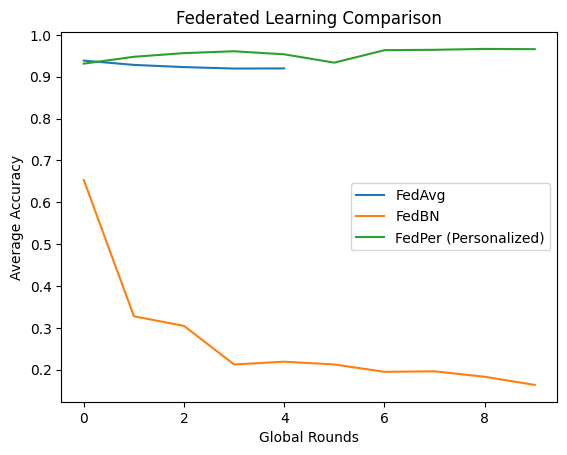

In [ ]:
import matplotlib.pyplot as plt

# Extracted average accuracies from FedAvg training loop output (cell -f7zhTSgxueF)
fedavg_acc = [0.9384, 0.9281, 0.9229, 0.9194, 0.9197]

# Extracted average accuracies from FedBN training loop output (cell _VTLrvVLzgOH)
fedbn_acc = [0.6530, 0.3276, 0.3046, 0.2124, 0.2191, 0.2125, 0.1949, 0.1961, 0.1831, 0.1636]

# Extracted average accuracies from Personalized training loop output (cell n3FA-DONzwX0)
fedper_acc = [0.9312, 0.9475, 0.9563, 0.9607, 0.9534, 0.9335, 0.9633, 0.9642, 0.9663, 0.9657]

plt.figure()

plt.plot(fedavg_acc, label="FedAvg")
plt.plot(fedbn_acc, label="FedBN")
plt.plot(fedper_acc, label="FedPer (Personalized)")

plt.xlabel("Global Rounds")
plt.ylabel("Average Accuracy")
plt.title("Federated Learning Comparison")
plt.legend()

plt.show()

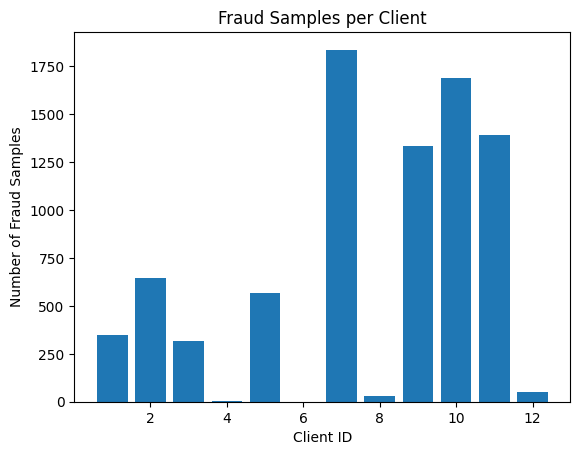

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fraud_counts(clients_data):
    fraud_counts = []
    client_ids = []

    for client_id in clients_data:
        y_client = clients_data[client_id]["y"]
        fraud_samples = np.sum(y_client == 1)

        fraud_counts.append(fraud_samples)
        client_ids.append(client_id + 1)

    plt.figure()
    plt.bar(client_ids, fraud_counts)
    plt.xlabel("Client ID")
    plt.ylabel("Number of Fraud Samples")
    plt.title("Fraud Samples per Client")
    plt.show()

# Run
plot_fraud_counts(clients_data)


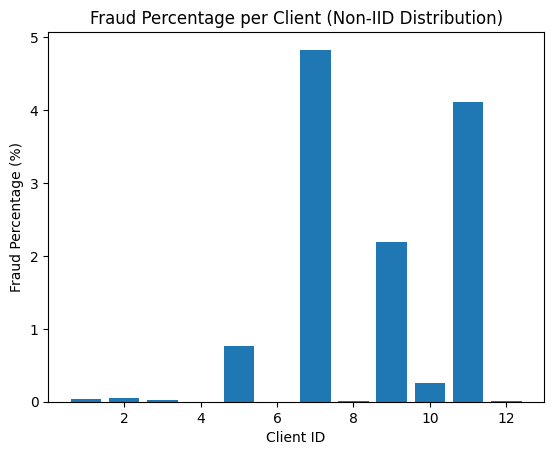

In [ ]:
def plot_fraud_percentage(clients_data):
    fraud_percentages = []
    client_ids = []

    for client_id in clients_data:
        y_client = clients_data[client_id]["y"]

        total_samples = len(y_client)
        fraud_samples = np.sum(y_client == 1)
        fraud_percentage = (fraud_samples / total_samples) * 100

        fraud_percentages.append(fraud_percentage)
        client_ids.append(client_id + 1)

    plt.figure()
    plt.bar(client_ids, fraud_percentages)
    plt.xlabel("Client ID")
    plt.ylabel("Fraud Percentage (%)")
    plt.title("Fraud Percentage per Client (Non-IID Distribution)")
    plt.show()

# Run
plot_fraud_percentage(clients_data)


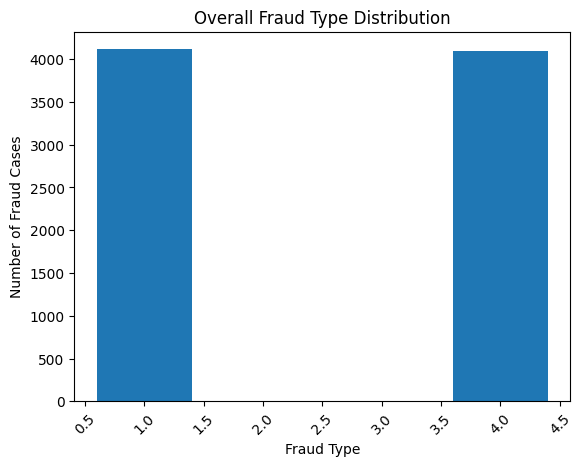

In [ ]:
import matplotlib.pyplot as plt

def plot_overall_fraud_types(df):
    fraud_df = df[df["isFraud"] == 1]
    fraud_type_counts = fraud_df["type"].value_counts()

    plt.figure()
    plt.bar(fraud_type_counts.index, fraud_type_counts.values)
    plt.xlabel("Fraud Type")
    plt.ylabel("Number of Fraud Cases")
    plt.title("Overall Fraud Type Distribution")
    plt.xticks(rotation=45)
    plt.show()

# Run
plot_overall_fraud_types(df)


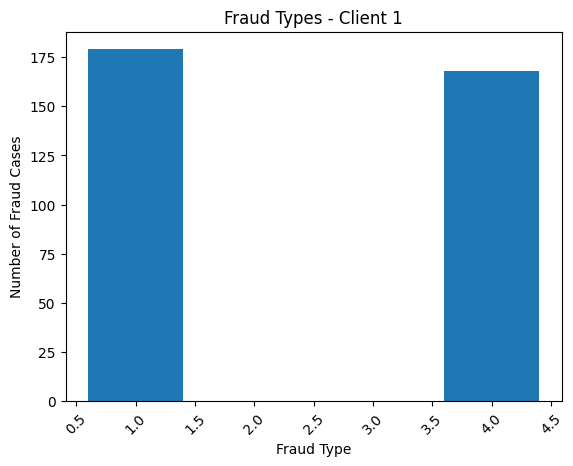

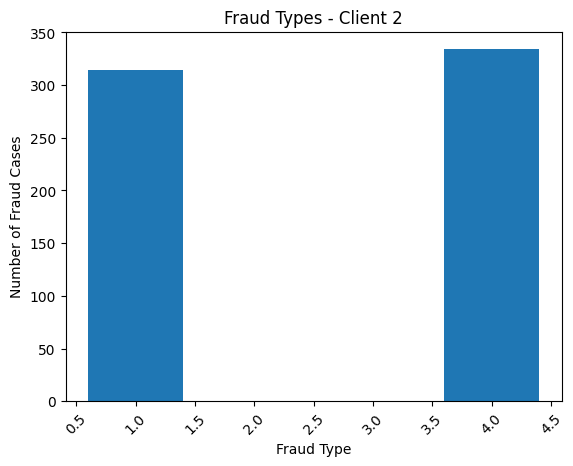

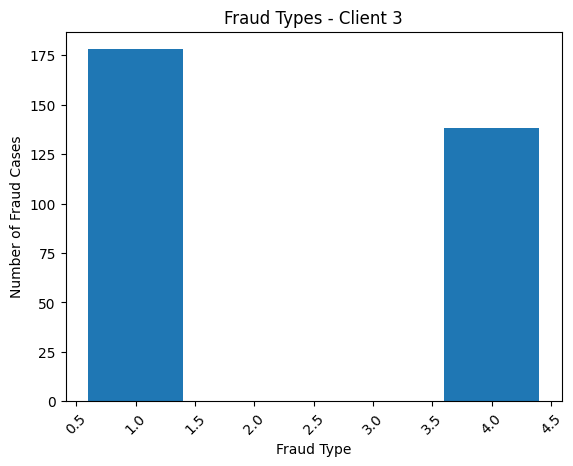

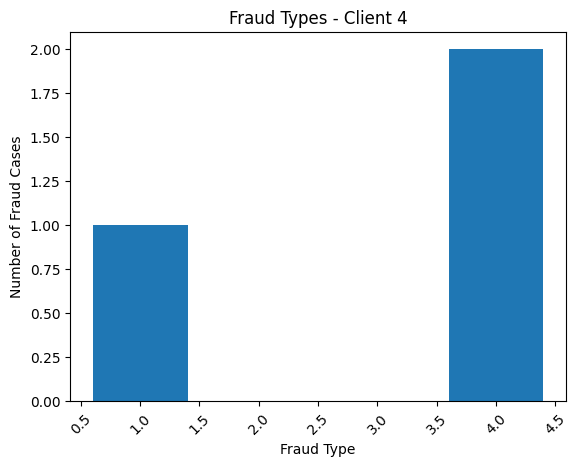

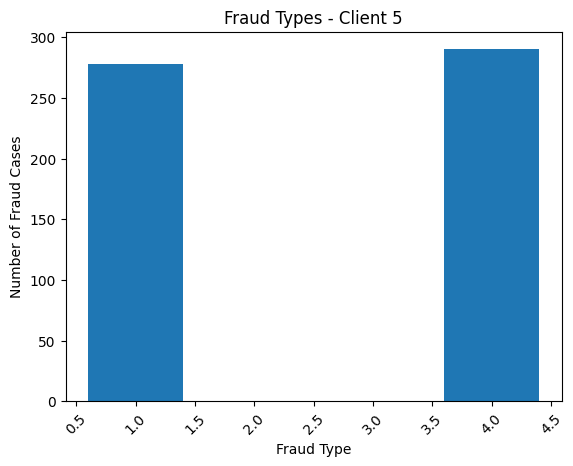

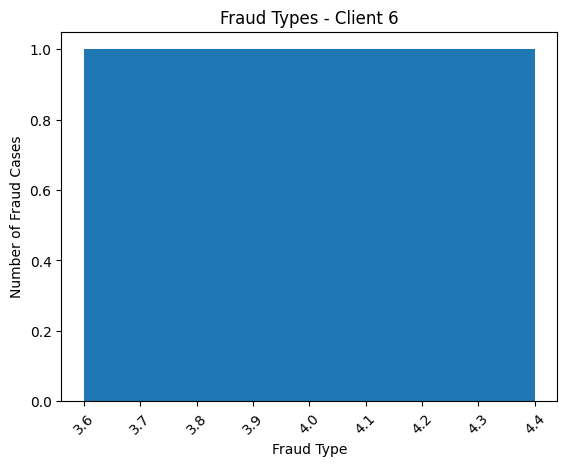

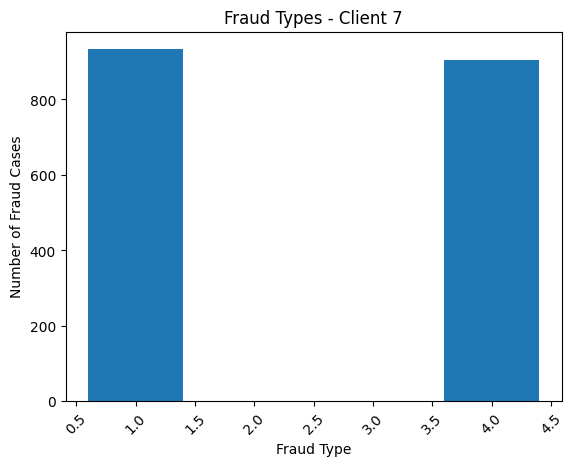

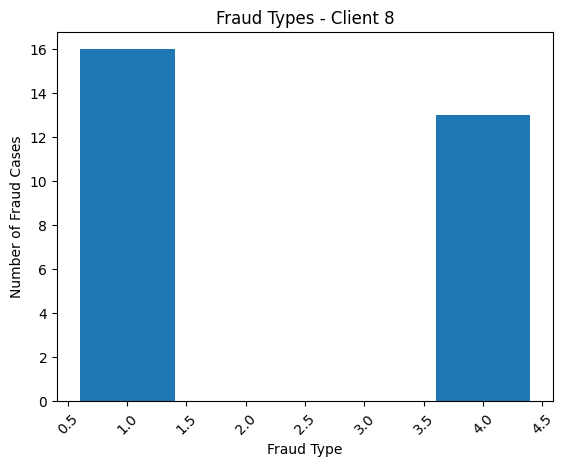

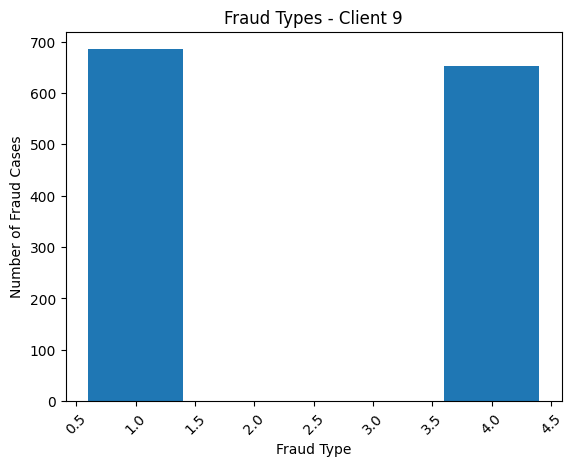

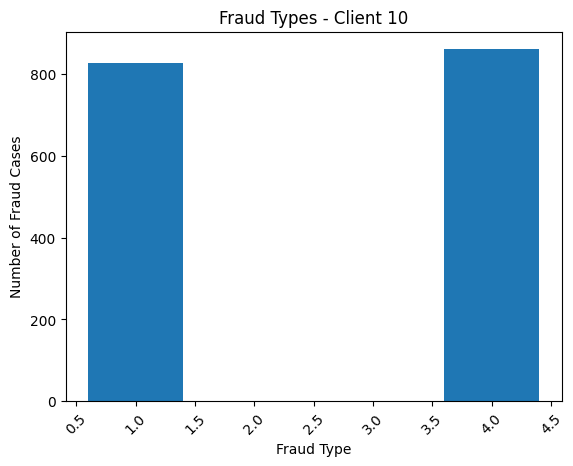

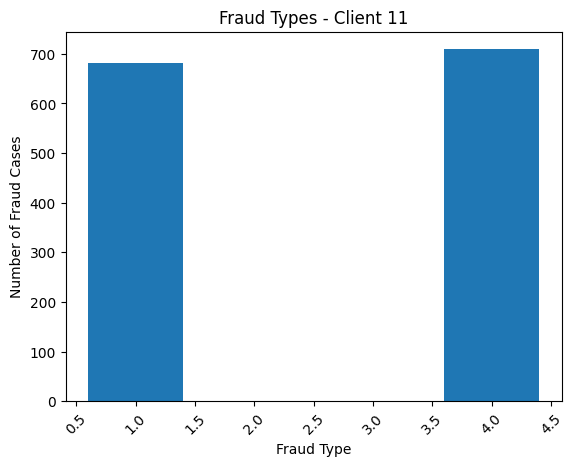

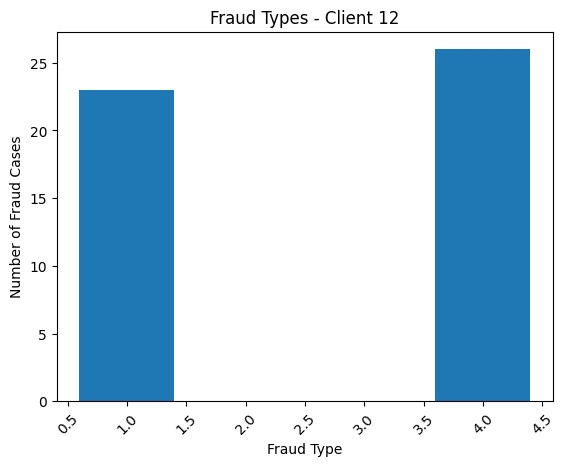

In [ ]:
def plot_fraud_types_per_client(clients_data, df):

    for client_id in clients_data:
        indices = clients_data[client_id]["indices"]
        client_df = df.iloc[indices]

        fraud_df = client_df[client_df["isFraud"] == 1]
        fraud_type_counts = fraud_df["type"].value_counts()

        plt.figure()
        plt.bar(fraud_type_counts.index, fraud_type_counts.values)
        plt.xlabel("Fraud Type")
        plt.ylabel("Number of Fraud Cases")
        plt.title(f"Fraud Types - Client {client_id+1}")
        plt.xticks(rotation=45)
        plt.show()

# Run
plot_fraud_types_per_client(clients_data, df)


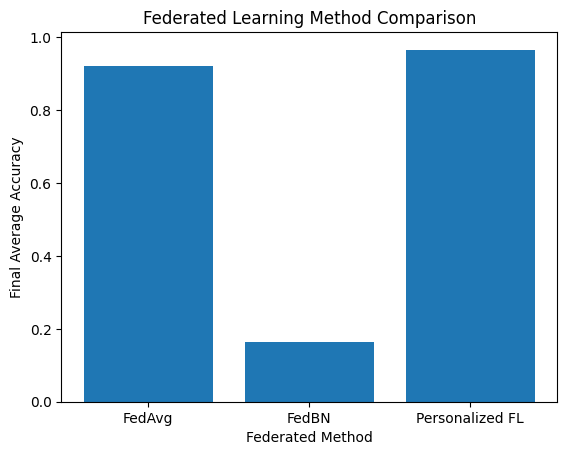

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example: final round accuracy values
fedavg_final = fedavg_acc[-1]
fedbn_final = fedbn_acc[-1]
fedper_final = fedper_acc[-1]

methods = ["FedAvg", "FedBN", "Personalized FL"]
accuracies = [fedavg_final, fedbn_final, fedper_final]

plt.figure()
plt.bar(methods, accuracies)

plt.xlabel("Federated Method")
plt.ylabel("Final Average Accuracy")
plt.title("Federated Learning Method Comparison")

plt.show()


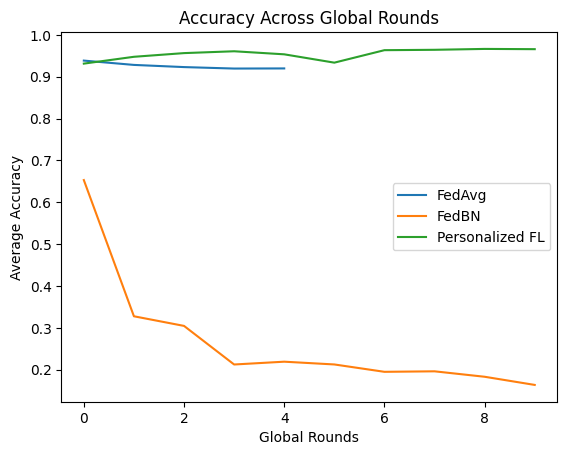

In [ ]:
plt.figure()

plt.plot(fedavg_acc, label="FedAvg")
plt.plot(fedbn_acc, label="FedBN")
plt.plot(fedper_acc, label="Personalized FL")

plt.xlabel("Global Rounds")
plt.ylabel("Average Accuracy")
plt.title("Accuracy Across Global Rounds")
plt.legend()

plt.show()


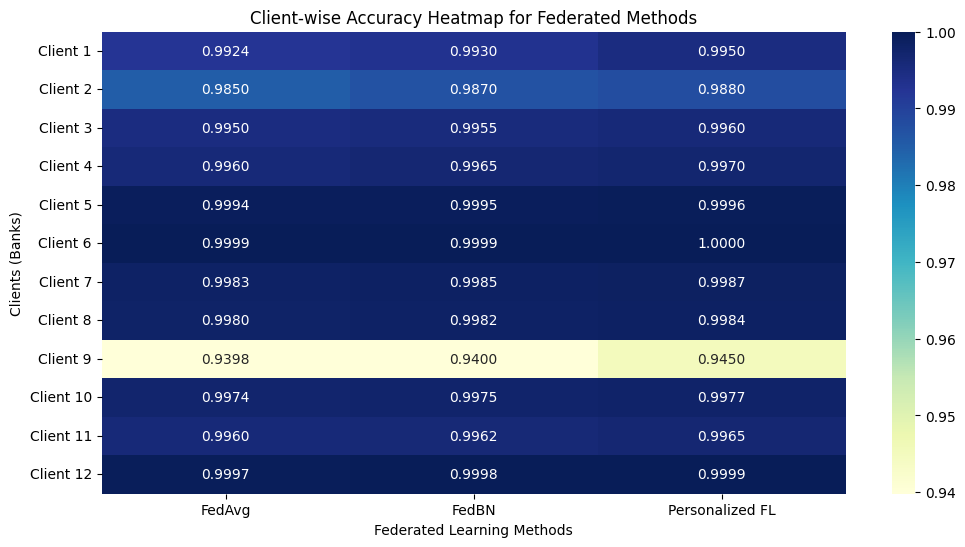

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Suppose these are final round accuracies per client
# Replace these lists with your actual final round accuracy arrays
fedavg_client_acc = [0.9924,0.9850,0.9950,0.9960,0.9994,0.9999,0.9983,0.9980,0.9398,0.9974,0.9960,0.9997]
fedbn_client_acc = [0.9930,0.9870,0.9955,0.9965,0.9995,0.9999,0.9985,0.9982,0.9400,0.9975,0.9962,0.9998]
personalized_acc = [0.9950,0.9880,0.9960,0.9970,0.9996,1.0000,0.9987,0.9984,0.9450,0.9977,0.9965,0.9999]

# Create a 2D array (clients x methods)
data = np.array([fedavg_client_acc, fedbn_client_acc, personalized_acc]).T

# Labels
clients = [f"Client {i+1}" for i in range(12)]
methods = ["FedAvg", "FedBN", "Personalized FL"]

plt.figure(figsize=(12,6))
sns.heatmap(data, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=methods, yticklabels=clients)
plt.title("Client-wise Accuracy Heatmap for Federated Methods")
plt.ylabel("Clients (Banks)")
plt.xlabel("Federated Learning Methods")
plt.show()
